## Reading in packages

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap
import matplotlib as mpl
import scanpy as sc
import scipy
import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
import sklearn
from sklearn import ensemble
import tqdm
from ripser import Rips
from sklearn.metrics.pairwise import euclidean_distances

import kmapper as km
from kmapper import jupyter
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
import plotly.graph_objs as go
import sys
from sklearn import ensemble

## Read in data

Select either the whole sc transformed dataset or just the variable genes

In [2]:
ILC_var = sc.read("sct_variable.h5ad")
ILC = sc.read("sct.h5ad")

c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
PCA_coord = ILC_var.obsm["X_pca"]
Diff_coord = ILC_var.obsm["X_diffmap"]

In [4]:
#norm_reads_sparse = ILC_var.layers["norm_data"]
norm_reads_sparse = ILC.layers["norm_data"]
norm_reads = pd.DataFrame(norm_reads_sparse.toarray())
print("Norm reads: "+repr(norm_reads.shape))

UMAP = ILC_var.obsm["umap_cell_embeddings"]
Diff = ILC_var.obsm['X_draw_graph_fa']

Norm reads: (26877, 15806)


## Selecting all ILC2 and ILC3 cells

### Run if writing csv files

In [5]:
Variable = ILC_var.var

Obs = ILC_var.obs
O = Obs["ilc2_ilc3"].to_frame()

Variable["Selected"].to_csv('Gene_list_ILC.csv', sep=',')
O.to_csv('Cell_list_ILC.csv', sep=',')

### Run if reading csv files

In [6]:
Gene_list = pd.read_csv("Gene_list_ILC.csv", sep=",", header = 0)
Gene_list = np.array(Gene_list)
Gene_list = Gene_list[:,0]
Cell_list = pd.read_csv("Cell_list_ILC.csv", sep=",", header = 0)
Cell_list = np.array(Cell_list)
Cell_list = Cell_list[:,0]

print("Gene list:"+repr(Gene_list))
print("Cell list:"+repr(Cell_list))

Gene list:array(['Yfp', 'Rb1cc1', 'Mcmdc2', ..., 'mt-Cytb', 'AC149090.1',
       'Cre (Il5)'], dtype=object)
Cell list:array(['Timept0.AAACCCAAGCTATCTG', 'Timept0.AAACCCAAGGTAATCA',
       'Timept0.AAACCCAAGTCTAACC', ..., 'Timept4.TTTGTTGCATCCAATG',
       'Timept4.TTTGTTGTCATTCATC', 'Timept4.TTTGTTGTCGCACTCT'],
      dtype=object)


## Collecting cells of interest

In this model of psoriasis, tissue resident ILC2s are reprogramed to ILC3s. 

For analysis we are selecting for cells likely to be ILC2s or ILC3s on the basis of previously characterized populations.

In [7]:
#Full matrix of all counts
matrix = ILC_var.layers["norm_data"]
matrix = np.array(matrix.toarray())

ILC_total_reads = pd.DataFrame(matrix, index = Cell_list, columns = Gene_list)
print(ILC_total_reads.shape)

(26877, 3000)


In [8]:
#We have four labeled groups of cells that we want to collect together
ILC2_ILC3 = ILC_var.obs["ilc2_ilc3"]
ILC3_Q = ILC_var.obs["quiescent_ilc3"]
ILC2_Q = ILC_var.obs["ilc2_quiescent"]
cloud_ILC3 = ILC_var.obs["cloud_ilc3"]

df = pd.DataFrame(dict(ILC2_ILC3 = ILC2_ILC3, ILC3_Q = ILC3_Q, ILC2_Q = ILC2_Q, cloud_ILC3 = cloud_ILC3))
cells = df.shape[0]

In [9]:
#binary yes ir no for if the cell is in our group
in_transition = np.zeros((cells, 1))

#Value of group - 0 if NA - over all cells
allcell_ILC2_ILC3 = np.zeros((cells, 1))
allcell_ILC3_Q = np.zeros((cells, 1))
allcell_ILC2_Q = np.zeros((cells, 1))
allcell_cloud_ILC3 = np.zeros((cells, 1))

#Cell labels - 0 if NA in all groups - over all cells
index_cells = np.zeros((cells, 1))
index_cells = index_cells.astype(str)

#Value of group - only cells in at least one group
val_ILC2_ILC3 = np.zeros((3807, 1))
val_ILC3_Q = np.zeros((3807, 1))
val_ILC2_Q = np.zeros((3807, 1))
val_cloud_ILC3 = np.zeros((3807, 1))

#Names of cells included in the value variables
index_val = np.array([])

#Variable for initially counting the number of cells in the groups of interest
number = 0


#Loops through the different groups so that we collect all cells with a value in at least one of the groups
for i in range(0,cells):
    if np.isnan(df["ILC2_ILC3"][i]):

        if np.isnan(df["ILC3_Q"][i]):

            if np.isnan(df["ILC2_Q"][i]):

                if np.isnan(df["cloud_ILC3"][i]):

                    in_transition[i,0] = 0
                    
                    allcell_ILC2_ILC3[i,0] = 0
                    allcell_ILC3_Q[i,0] = 0
                    allcell_ILC2_Q[i,0] = 0
                    allcell_cloud_ILC3[i,0] = 0
                    
                    index_cells[i,0] = "0"
                    
                else:
                    in_transition[i,0] = 1
                    
                    allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                    allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                    allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                    allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                    
                    index_cells[i,0] = Cell_list[i]
                    
                    val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                    val_ILC3_Q[number] = df["ILC3_Q"][i]
                    val_ILC2_Q[number] = df["ILC2_Q"][i]
                    val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                    
                    index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                    
                    number += 1
            else:
                in_transition[i,0] = 1
                
                allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                
                index_cells[i,0] = Cell_list[i]
                
                val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                val_ILC3_Q[number] = df["ILC3_Q"][i]
                val_ILC2_Q[number] = df["ILC2_Q"][i]
                val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                
                index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                
                number += 1             

        else:
            in_transition[i,0] = 1
            
            allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
            allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
            allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
            allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
            
            index_cells[i,0] = Cell_list[i]
            
            val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
            val_ILC3_Q[number] = df["ILC3_Q"][i]
            val_ILC2_Q[number] = df["ILC2_Q"][i]
            val_cloud_ILC3[number] = df["cloud_ILC3"][i]
            
            index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
            
            number += 1
    
    else:
        in_transition[i,0] = 1
        
        allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
        allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
        allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
        allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
        
        index_cells[i,0] = Cell_list[i]
        
        val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
        val_ILC3_Q[number] = df["ILC3_Q"][i]
        val_ILC2_Q[number] = df["ILC2_Q"][i]
        val_cloud_ILC3[number] = df["cloud_ILC3"][i]
        
        index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
        
        number += 1
      

print(number)

3807


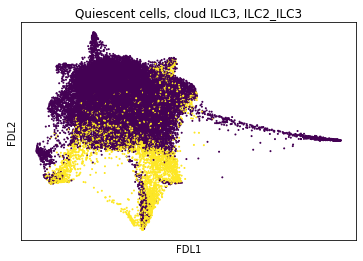

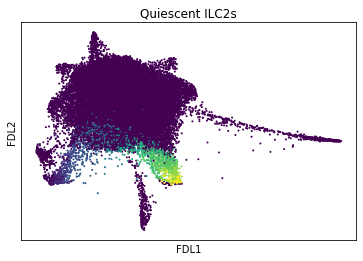

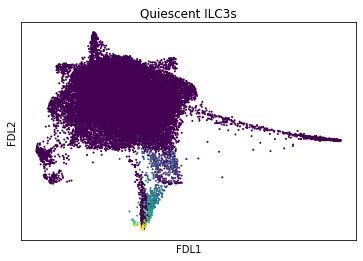

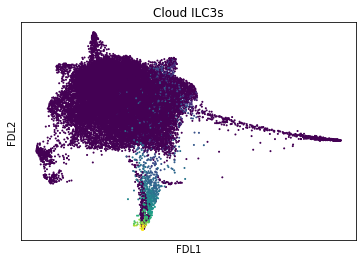

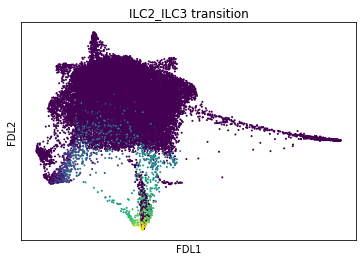

In [10]:
#There are some nan values in these arrays that we want to force to zero
val_ILC2_ILC3[np.isnan(val_ILC2_ILC3)] = 0
val_ILC3_Q[np.isnan(val_ILC3_Q)] = 0
val_ILC2_Q[np.isnan(val_ILC2_Q)] = 0
val_cloud_ILC3[np.isnan(val_cloud_ILC3)] = 0  

frame1 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = in_transition)
plt.title('Quiescent cells, cloud ILC3, ILC2_ILC3')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame2 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC2_Q)
plt.title('Quiescent ILC2s')
#plt.xlim(-30000,25000)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame3 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC3_Q)
plt.title('Quiescent ILC3s')
frame3.axes.get_xaxis().set_ticks([])
frame3.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame4 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_cloud_ILC3)
plt.title('Cloud ILC3s')
frame4.axes.get_xaxis().set_ticks([])
frame4.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame5 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC2_ILC3)
plt.title('ILC2_ILC3 transition')
frame5.axes.get_xaxis().set_ticks([])
frame5.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

### Creating normalized read matrix for only the cells of interest

In [11]:
#Numpy array with normalized reads for all cells
norm_reads = np.array(norm_reads)
print(norm_reads.shape)
PCA_coord = np.array(PCA_coord)
print(PCA_coord.shape)
Diff_coord = np.array(Diff_coord)
print(Diff_coord.shape)

#Number of genes to initialize new matrix
genes = Gene_list.shape[0]
reads = np.zeros((1,15806 ))

PCA_reads = np.zeros((1,50))
Diff_reads = np.zeros((1,15))

#Going through all of the cells, if the  associated index in index_cell is nonzero then 
#it was included in our group and we should pull the associated gene expression data
for i in range(0,cells):
    j = index_cells[i]
    if j != "0":
        next_cell = norm_reads[i,:]
        next_cell = np.reshape(next_cell, (1,15806 ))
        reads = np.append(reads, next_cell, axis = 0)
        
        next_PCA = PCA_coord[i,:]
        next_PCA = np.reshape(next_PCA, (1,50))
        PCA_reads = np.append(PCA_reads, next_PCA, axis = 0)
        
        next_Diff = Diff_coord[i,:]
        next_Diff = np.reshape(next_Diff, (1,15))
        Diff_reads = np.append(Diff_reads, next_Diff, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
reads = reads[1:, :]    
PCA_reads = PCA_reads[1:, :]
Diff_reads = Diff_reads[1:, :]

(26877, 15806)
(26877, 50)
(26877, 15)


# Save or read in matrix with cells of interest

In [12]:
np.savetxt("ILCs_reads.csv", reads, delimiter=',')
np.savetxt("ILCs_index.csv", index_val, delimiter=',', fmt="%s")
np.savetxt("index_cells.csv", index_cells, delimiter=',', fmt="%s")

In [13]:
ILCs_reads = pd.read_csv("ILCs_reads.csv", sep=",", header = None) #Normalized gene expression of cells of interest
ILCs_reads_values = np.array(ILCs_reads)

ILCs_index = pd.read_csv("ILCs_index.csv", sep=",", header = None)

## Distance Matrix

In [14]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection

In [15]:
np_data = np.array(ILC_total_reads)
N, d = np_data.shape
dist_mat = euclidean_distances(np_data, np_data)

In [15]:
#dist_mat = np.zeros((N, N))

#for j in range(N):
#    for k in range(0,N):
#        if j != k:
#            dist_mat[j, k] = np.linalg.norm(np_data[j, :] - np_data[k, :])
            
            
#    if j % 1000 == 0:
#        print("J: "+repr(j))
#        print("N: "+repr(N))

In [16]:
#savetxt('dist_mat_ILC.csv', dist_mat, delimiter=',')

#dist_mat = pd.read_csv('dist_mat_ILC.csv', sep=",", header = None)
#dist_mat = np.array(dist_mat )

In [16]:
print(dist_mat.shape)

(26877, 26877)


## Witness complex

In [17]:
from time import time
import numpy as np
from tda_utils.density_filtration import sort_distances_per_point, indices_for_density_filtration
from tda_utils.witness_complex import *

dist_per_pt = sort_distances_per_point(dist_mat)

# Load in ILC data
sct_sparse = np_data
dist_mat = dist_mat
n, d = sct_sparse.shape
print("n = "+str(n))
print("d = "+str(d))
print("shape of dist_mat: "+str(dist_mat.shape))

# Load in distances per point
distances_per_point = dist_per_pt

# time computation of density filtrations
print("Timing computation of density filtrations...")
density_indices = dict()
density_filtrations = dict()
ks = [10, 100, 1000]
#      10000]
ps = [0.01, 0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        print("\tk = "+str(k)+", p = "+str(p)+":")
        start = time()
        indices = indices_for_density_filtration(distances_per_point, k, p)
        density_indices[(k, p)] = indices
        mask = np.zeros(n, dtype=bool)
        mask[indices] = True
        sqr_mask = np.outer(mask, mask)
        density_filtrations[(k, p)] = np.reshape(dist_mat[sqr_mask], (len(indices), len(indices)))
        print("\t"+str(time()-start)+" seconds\n")

print("Timing computation of landmarks...")
landmark_indices = dict()
landmark_mats = dict()
pps = [0.05, 0.1, 0.2]
for k in ks:
    for p in ps:
        for pp in pps:
            print("\tk = "+str(k)+", p = "+str(p)+", pp = "+str(pp)+":")
            start = time()
            landmark_indices[(k, p, pp)], landmark_mats[(k, p, pp)] = choose_landmarks(density_filtrations[(k, p)], pp)
            print("\t"+str(time()-start)+" seconds\n")

print("Printing numbers of landmarks...")
for k in ks:
    for p in ps:
        for pp in pps:
            toople = (k, p, pp)
            print(str(toople)+": "+str(len(landmark_indices[toople])))
            if toople == (1000, 0.2, 0.2):
                print("saving")
                landmark_inds = landmark_indices[toople]
                dense_inds = density_indices[(k, p)]
                true_inds = [dense_inds[ind] for ind in landmark_inds]
                print(true_inds)
                to_save = np.vstack([sct_sparse[ind, :] for ind in true_inds])
                np.save("ILC_landmarks.npy", to_save)
                np.save("ILC_landmark_indices.npy", true_inds)

n = 26877
d = 3000
shape of dist_mat: (26877, 26877)
Timing computation of density filtrations...
	k = 10, p = 0.01:
	0.7136223316192627 seconds

	k = 10, p = 0.05:
	0.8007752895355225 seconds

	k = 10, p = 0.1:
	0.9353315830230713 seconds

	k = 10, p = 0.2:
	1.3576185703277588 seconds

	k = 100, p = 0.01:
	0.7498836517333984 seconds

	k = 100, p = 0.05:
	0.8056347370147705 seconds

	k = 100, p = 0.1:
	0.9084012508392334 seconds

	k = 100, p = 0.2:
	1.3597021102905273 seconds

	k = 1000, p = 0.01:
	0.7687175273895264 seconds

	k = 1000, p = 0.05:
	0.8163130283355713 seconds

	k = 1000, p = 0.1:
	0.8874721527099609 seconds

	k = 1000, p = 0.2:
	1.350367784500122 seconds

Timing computation of landmarks...
	k = 10, p = 0.01, pp = 0.05:
	0.006003856658935547 seconds

	k = 10, p = 0.01, pp = 0.1:
	0.0 seconds

	k = 10, p = 0.01, pp = 0.2:
	0.0 seconds

	k = 10, p = 0.05, pp = 0.05:
	0.0020008087158203125 seconds

	k = 10, p = 0.05, pp = 0.1:
	0.0010004043579101562 seconds

	k = 10, p = 0.0

## Visualize Landmarks

In [18]:
landmarks = np.load("ILC_landmarks.npy")

landmarks = true_inds
print(true_inds)

[20029, 22399, 23644, 10633, 24960, 7368, 16080, 2907, 25367, 6211, 8878, 26408, 16753, 10401, 11149, 5490, 3860, 6454, 10893, 15586, 9265, 26331, 6808, 23110, 19041, 3576, 24540, 25422, 16443, 22694, 6169, 3603, 21955, 7199, 15937, 20708, 8416, 16756, 6866, 17258, 12495, 7659, 20071, 18218, 1774, 9372, 6981, 8726, 23406, 4050, 22628, 6332, 2505, 24110, 1159, 15, 7963, 16013, 20282, 5976, 18174, 10530, 9549, 20218, 9097, 3348, 2903, 17023, 10589, 22231, 16549, 18675, 23081, 5550, 26794, 4631, 93, 22783, 17181, 15466, 17418, 15601, 766, 12060, 4831, 25149, 25721, 21593, 21753, 14009, 26218, 9343, 16196, 5188, 8656, 616, 8131, 5944, 8056, 24264, 15549, 714, 8318, 15634, 26003, 17247, 25848, 6200, 16253, 5838, 3733, 7473, 16147, 22125, 22549, 9344, 9126, 6199, 26049, 26870, 21711, 371, 21146, 17469, 11701, 26396, 17783, 11892, 3426, 1644, 15797, 21363, 3260, 4365, 23842, 22371, 8453, 20858, 4206, 24775, 21543, 448, 16118, 2155, 3990, 23488, 7476, 5905, 15888, 5846, 2416, 20326, 439, 26849

In [19]:
N, d = np_data.shape

UMAP = np.array(UMAP)
print(UMAP.shape)

UMAP_landmark = np.zeros((1,2))
data_landmark = np.zeros((1,d))

#Going through all of the cells, if index in landmarks we should pull the associated gene expression data
for i in landmarks:
    next_cell = np_data[i,:]
    next_cell = np.reshape(next_cell, (1, d))
    data_landmark = np.append(data_landmark, next_cell, axis = 0)
        
    next_embedding = UMAP[i,:]
    next_embedding = np.reshape(next_embedding, (1,2))
    UMAP_landmark = np.append(UMAP_landmark, next_embedding, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
data_landmark = data_landmark[1:, :]    
UMAP_landmark = UMAP_landmark[1:, :]

print(data_landmark.shape)
print(UMAP_landmark.shape)

(26877, 2)
(1075, 3000)
(1075, 2)


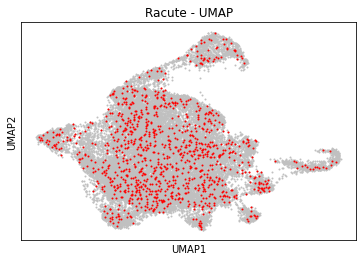

In [20]:
frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=1, c = "silver")
frame1 = plt.scatter(UMAP_landmark[:,0], UMAP_landmark[:,1], s=1, c = "red")
plt.title('Racute - UMAP')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

## Persistence Diagrams

In [ ]:
#rips = Rips()
#diagrams = rips.fit_transform(np_data, distance_matrix=False, metric="euclidean")
#rips.plot(diagrams)

In [ ]:
rips = Rips()
diagrams = rips.fit_transform(data_landmark, distance_matrix=False, metric="euclidean")
rips.plot(diagrams)

## Eigen plots

In [22]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection, eigen_plot_numPoints, eigen_calc_from_dist_mat_withNumPoints
from manifold_utils.iga import chakraborty_express, iga

In [23]:
#for i in range(len(landmarks)):
#    print(landmarks[i])
#    center = landmarks[i]
#    radii, eigval_list, eigvec_list = eigen_calc_from_dist_mat(np_data, dist_mat, center, radint = .01)

#    rmin = radii[0]
#    rmax = radii[-1]
    
#    eigen_plot(eigval_list, radii, rmin, rmax)

18685


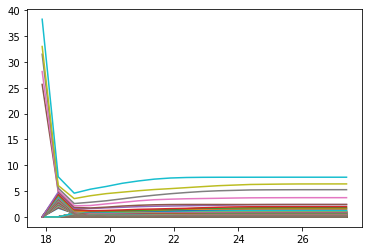

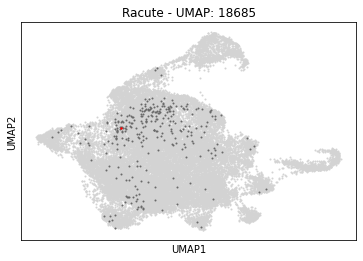

6131


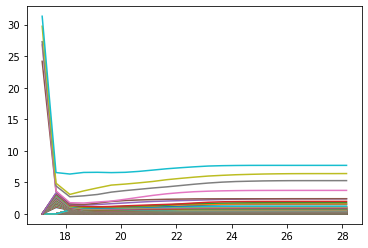

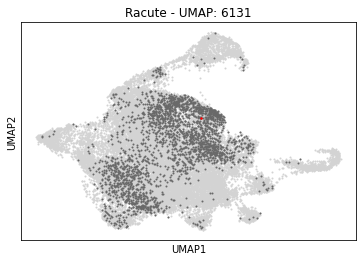

21891


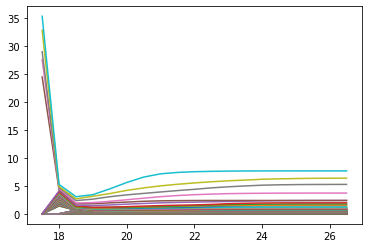

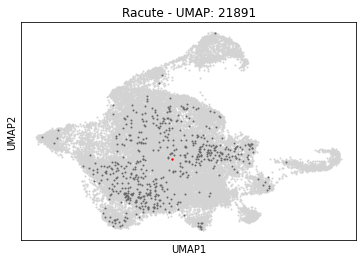

8428


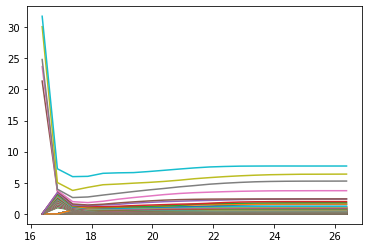

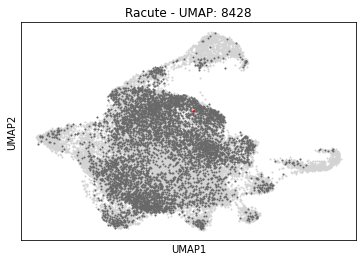

4065


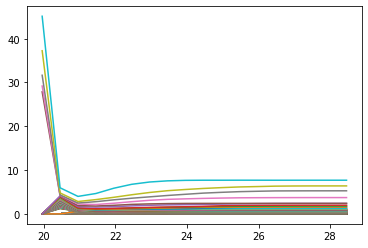

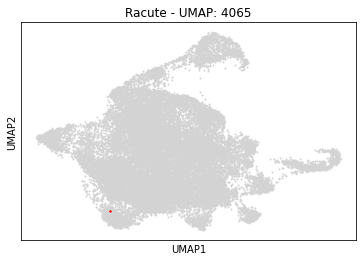

1546


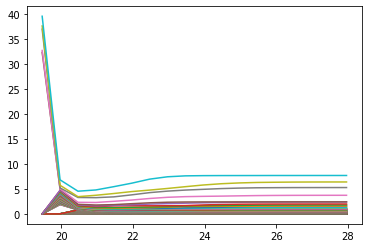

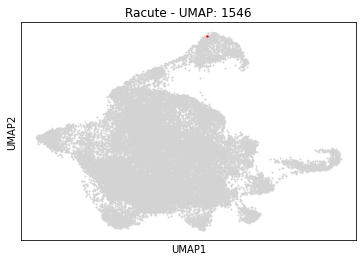

22529


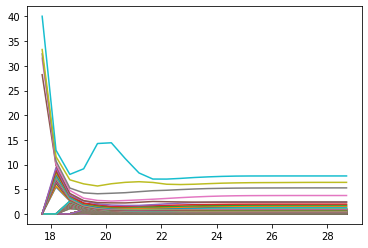

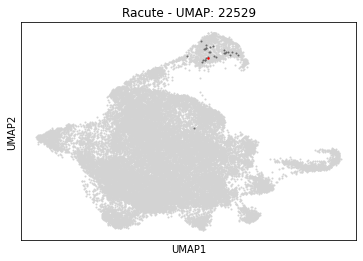

16436


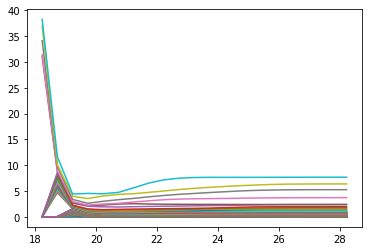

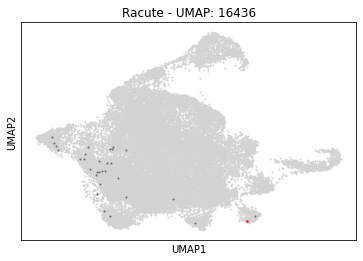

4968


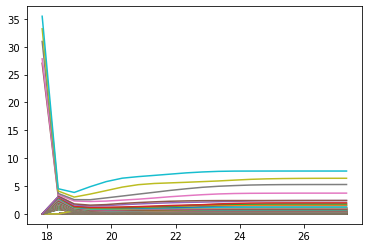

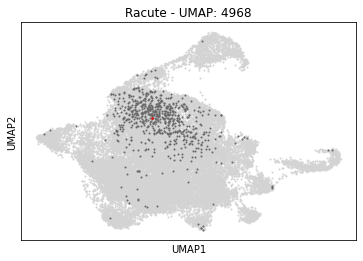

25390


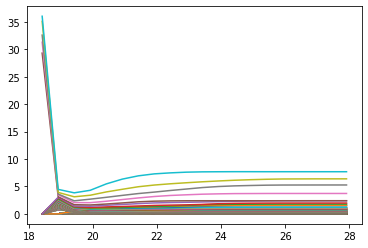

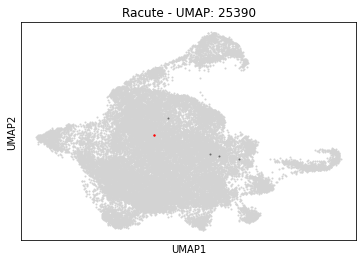

1244


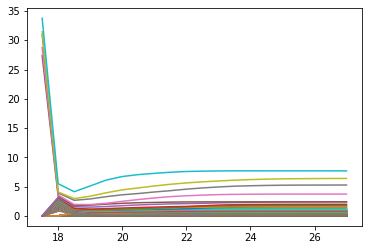

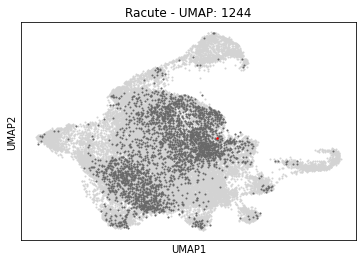

1446


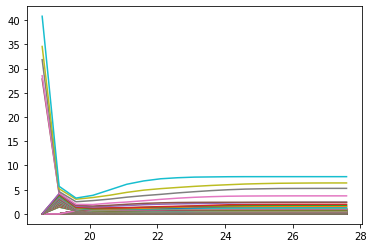

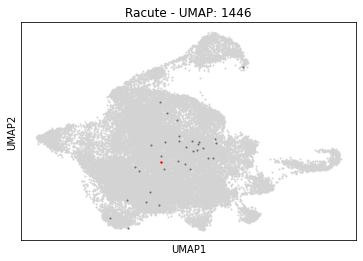

1632


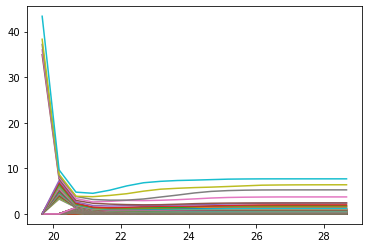

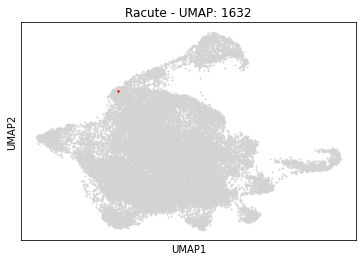

26408


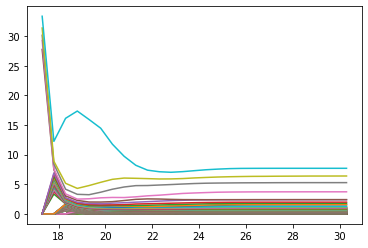

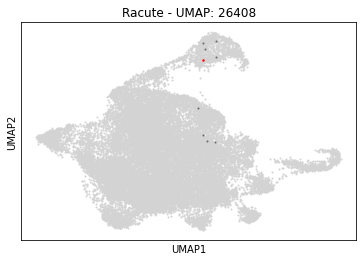

24627


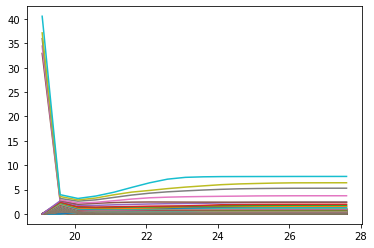

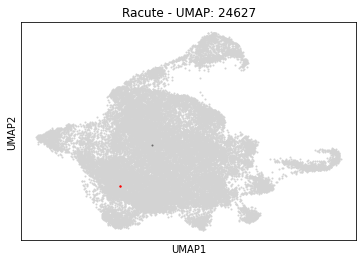

156


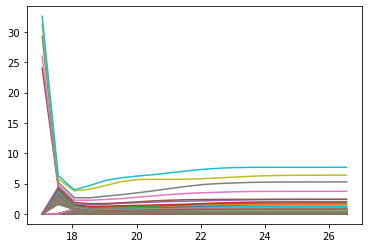

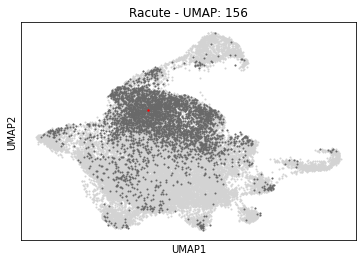

323


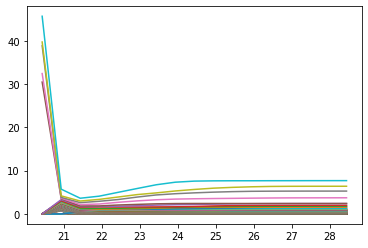

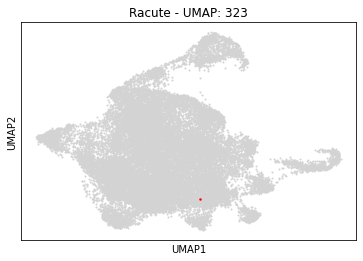

20631


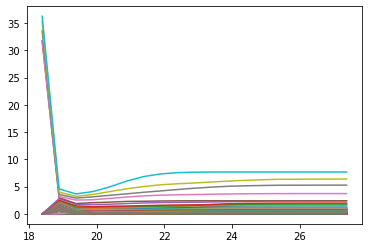

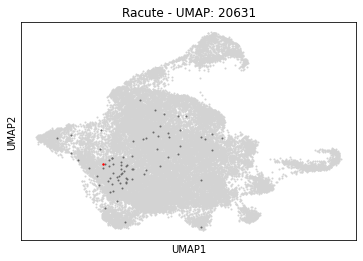

17211


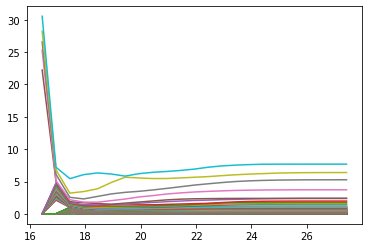

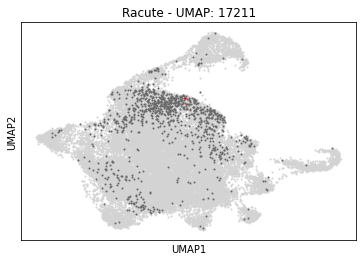

22550


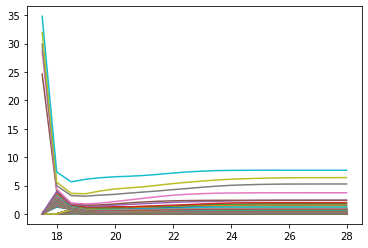

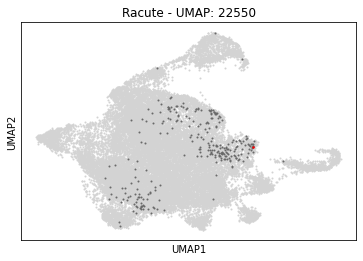

24109


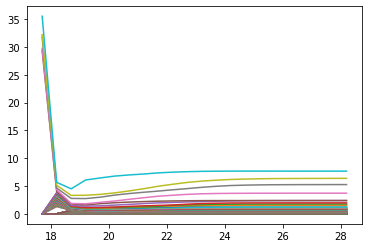

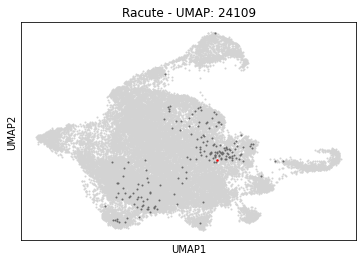

20458


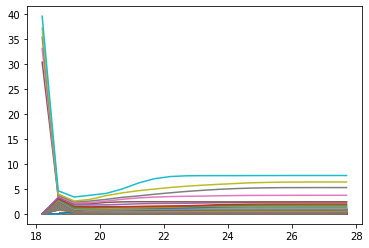

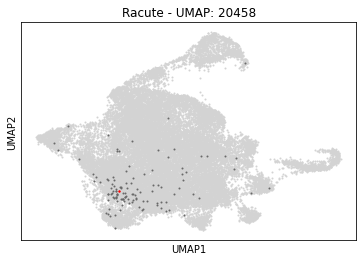

21763


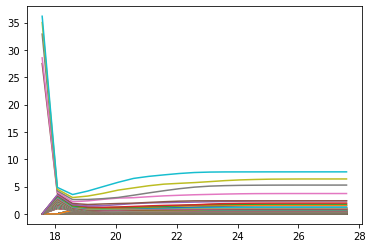

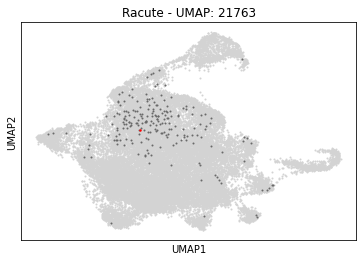

7358


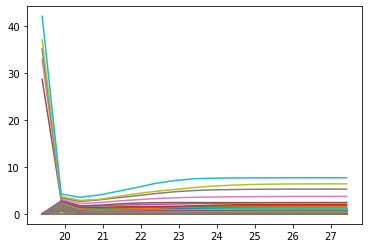

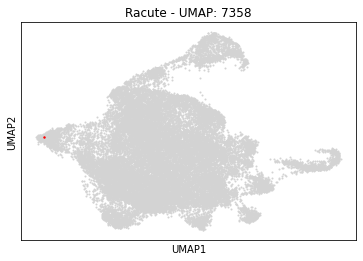

5989


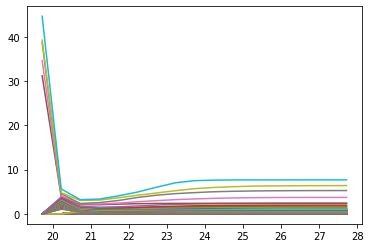

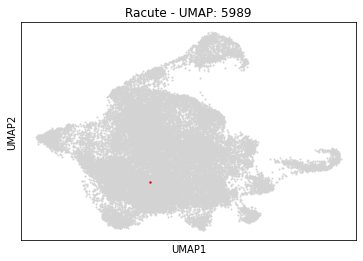

2313


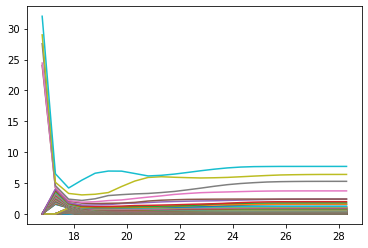

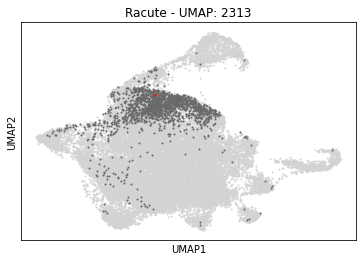

8385


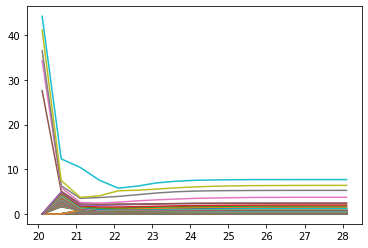

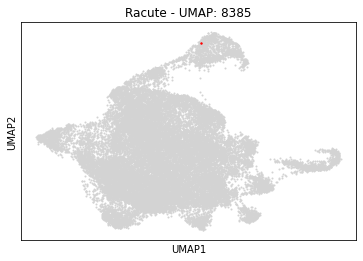

8672


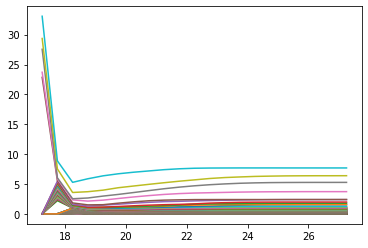

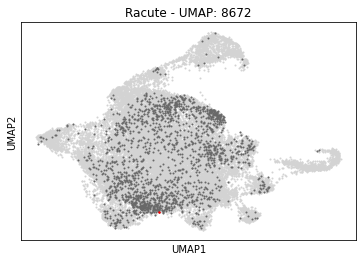

13647


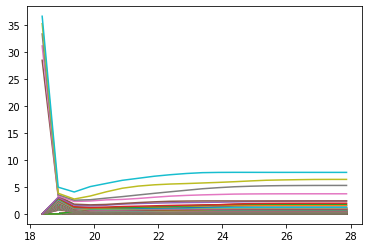

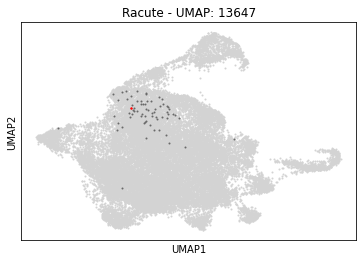

8949


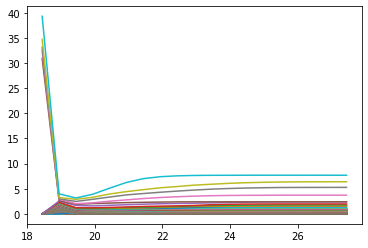

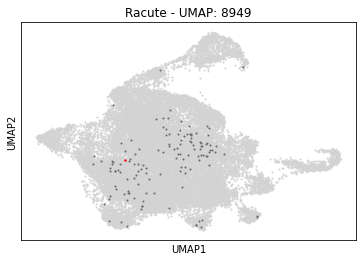

7519


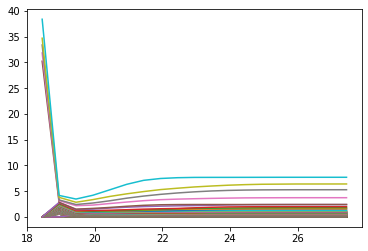

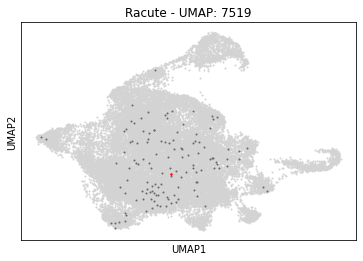

7804


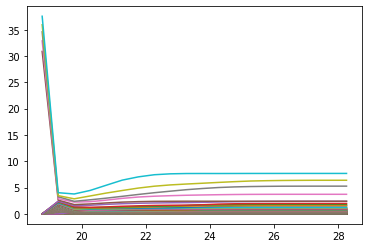

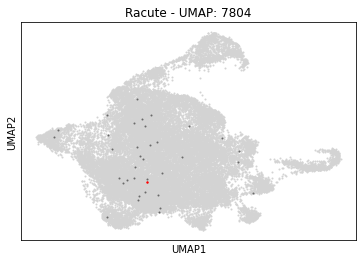

7323


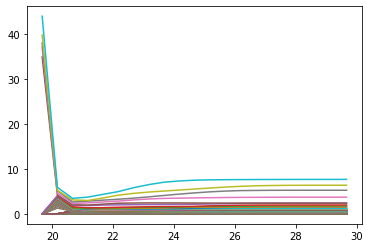

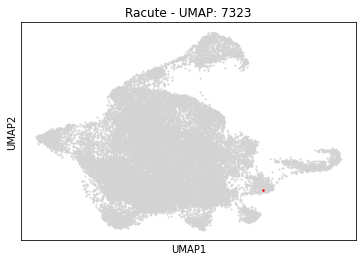

17530


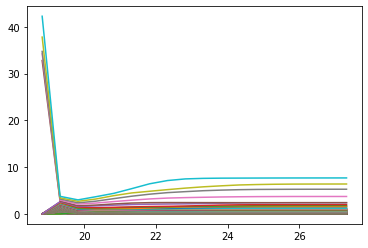

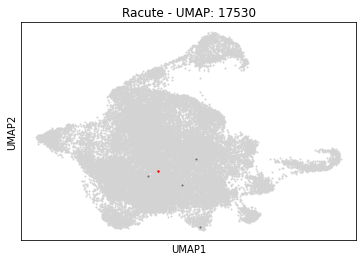

545


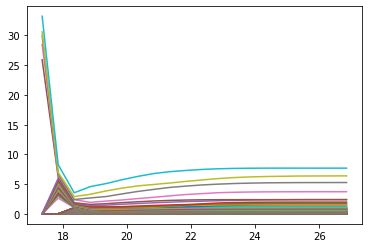

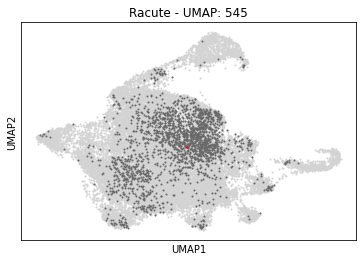

25410


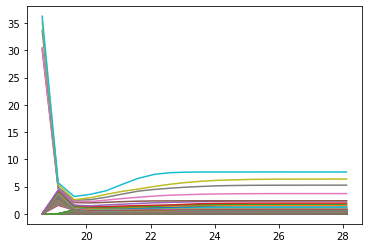

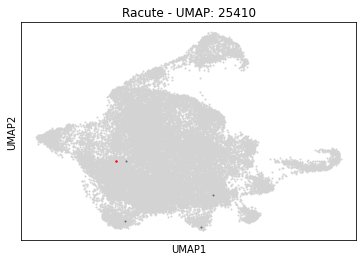

3233


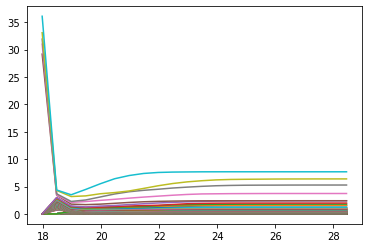

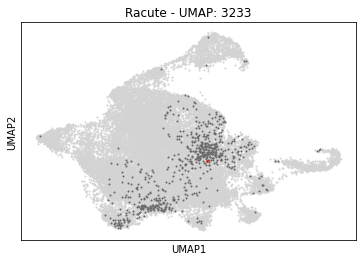

10543


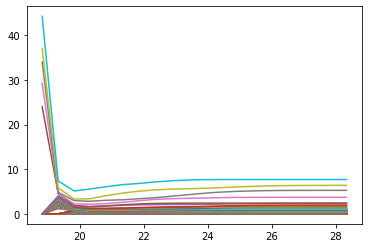

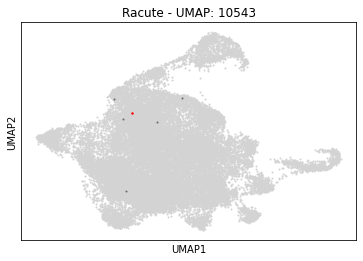

12053


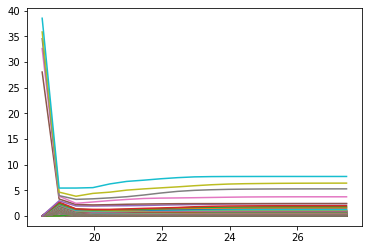

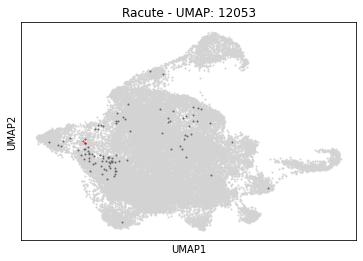

6481


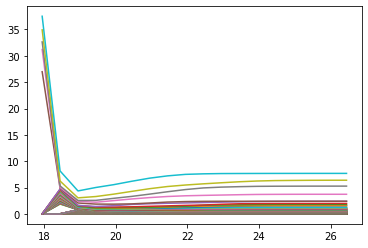

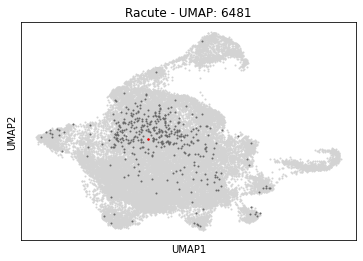

5406


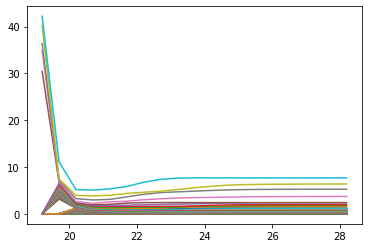

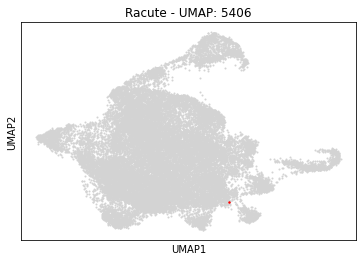

6724


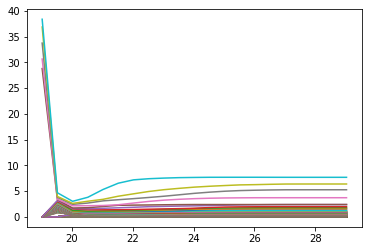

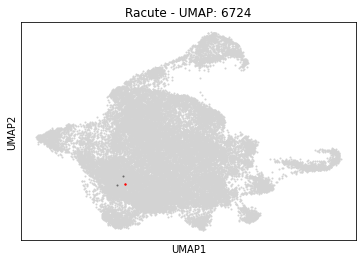

5547


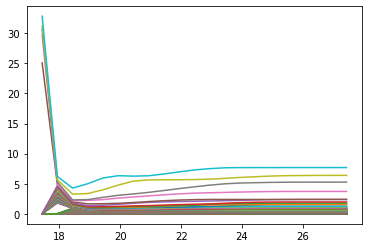

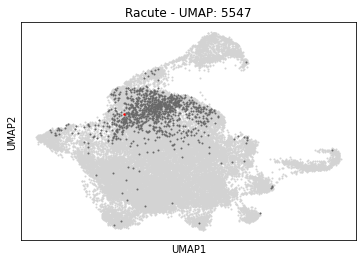

2288


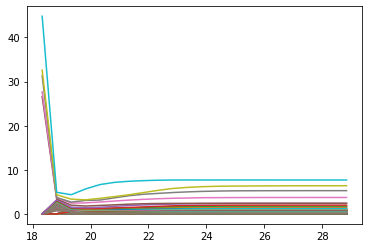

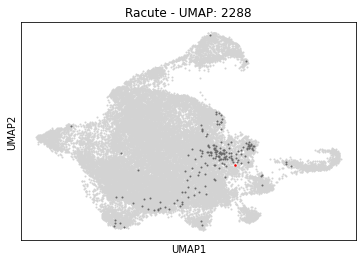

10541


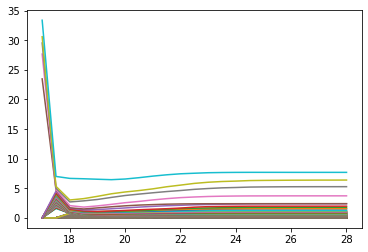

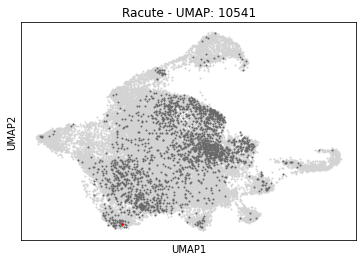

4024


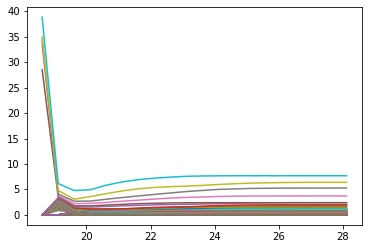

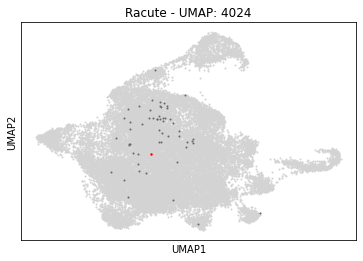

11660


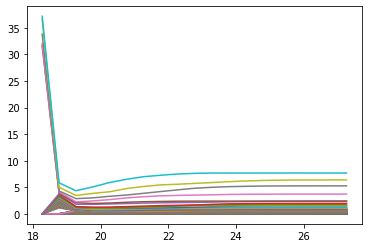

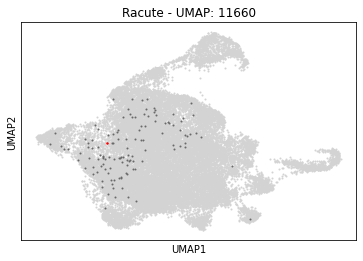

14500


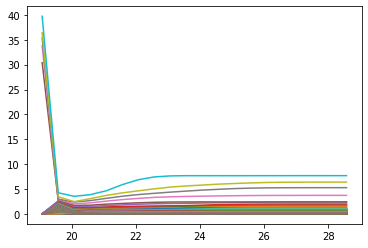

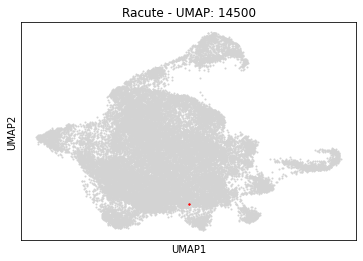

19097


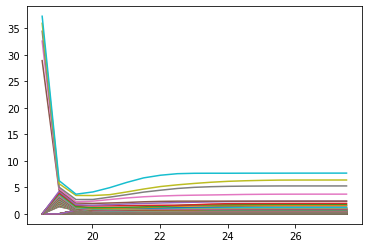

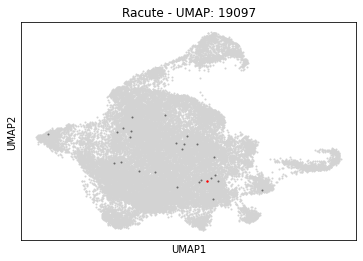

9153


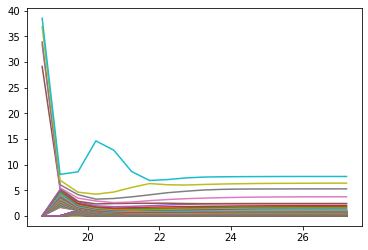

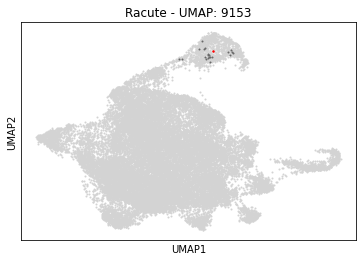

23741


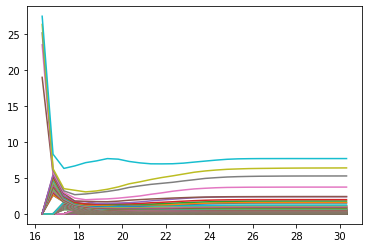

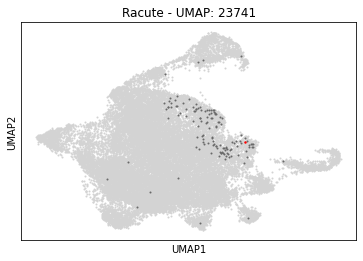

25863


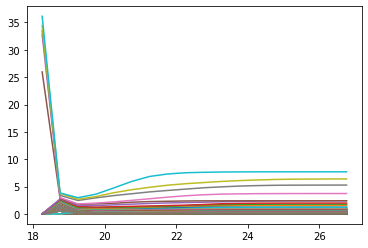

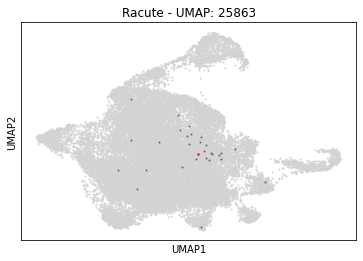

6921


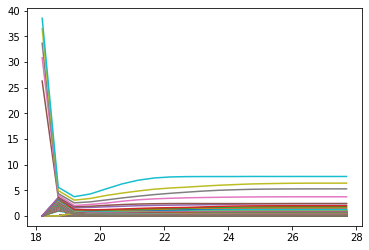

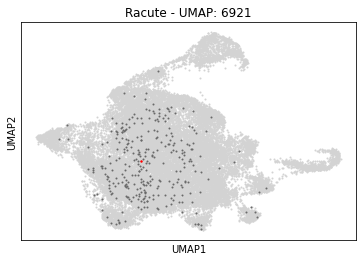

13005


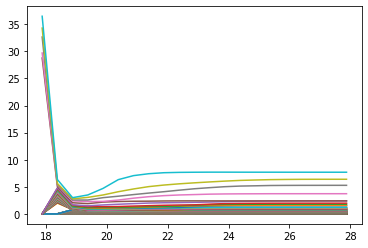

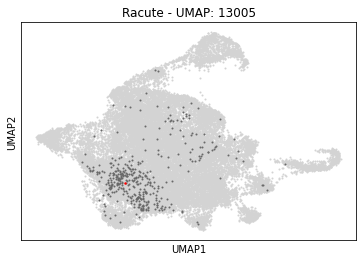

26786


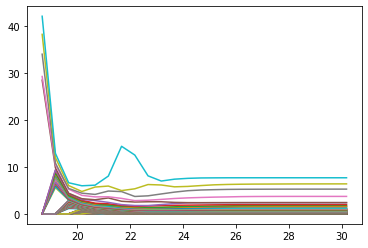

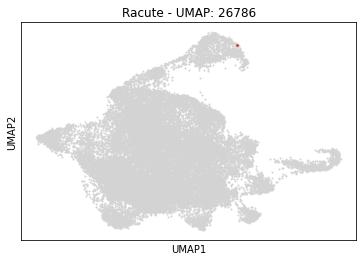

6990


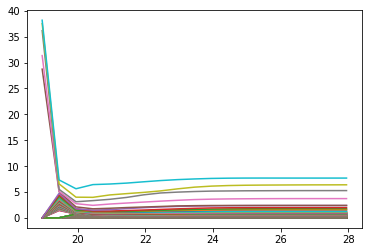

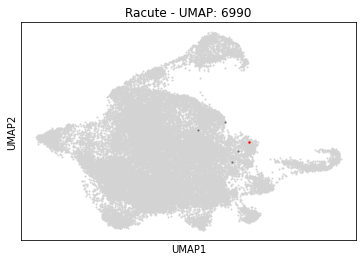

7590


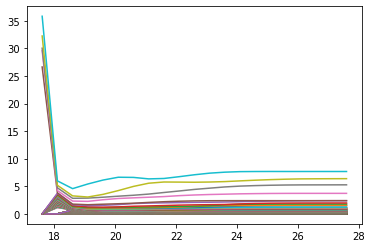

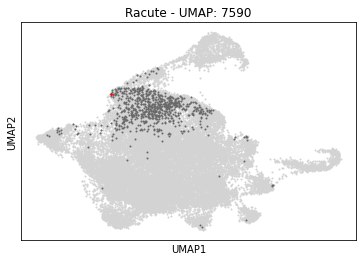

4053


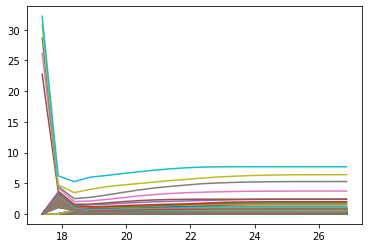

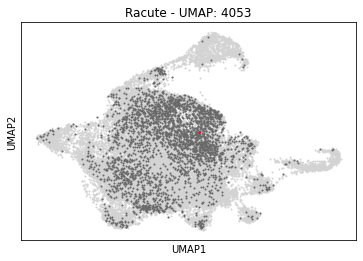

15718


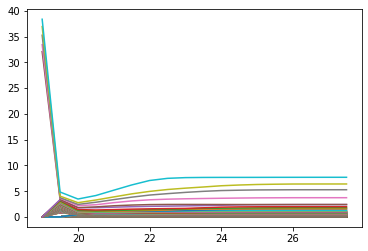

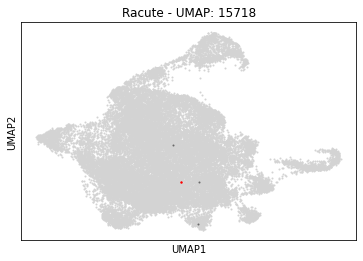

22477


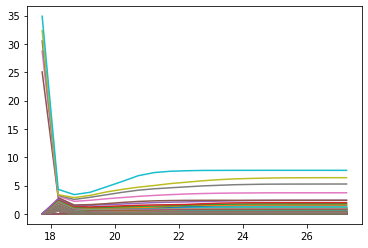

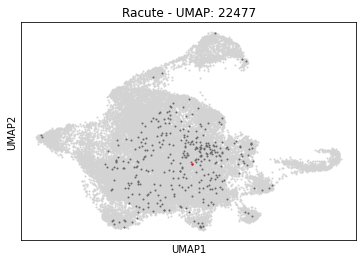

2321


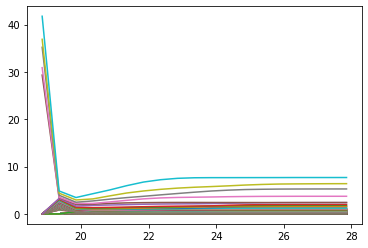

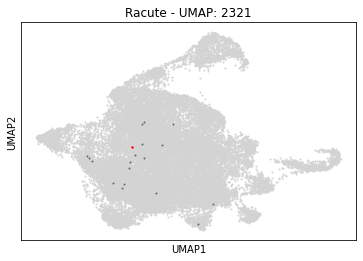

2539


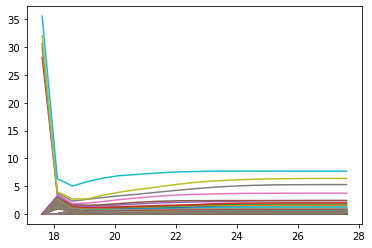

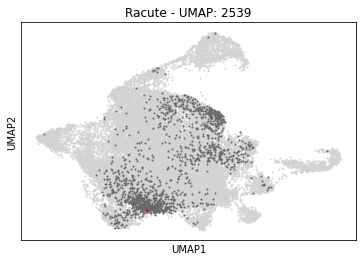

6015


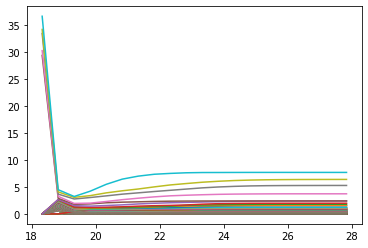

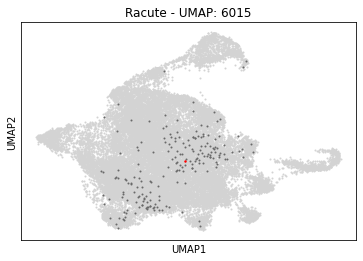

22715


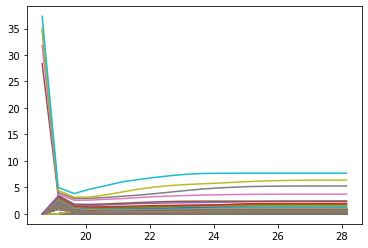

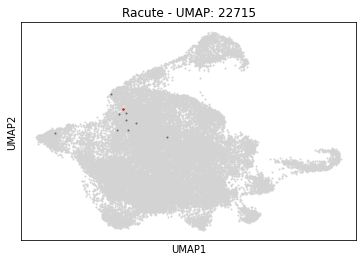

15394


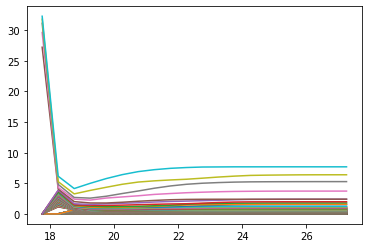

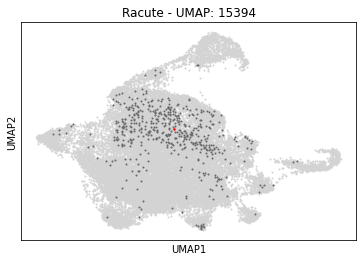

4257


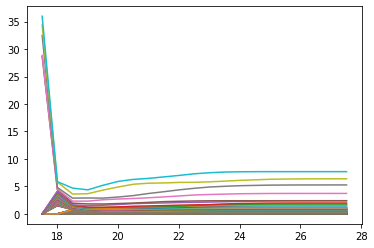

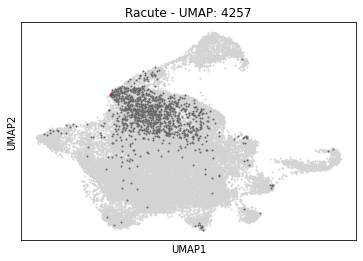

23014


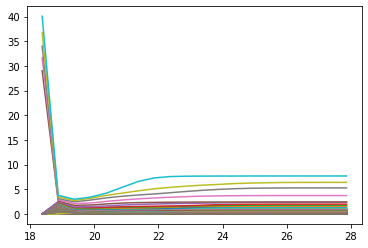

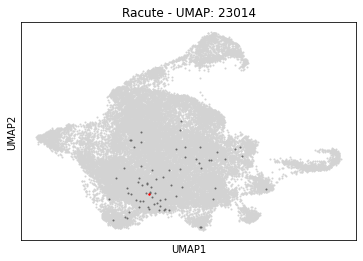

6882


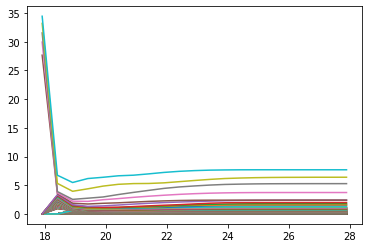

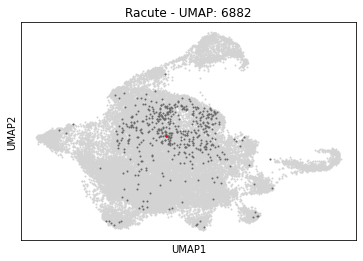

7473


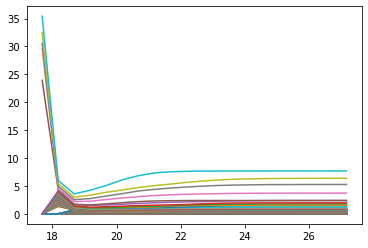

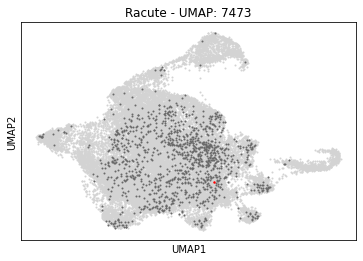

7676


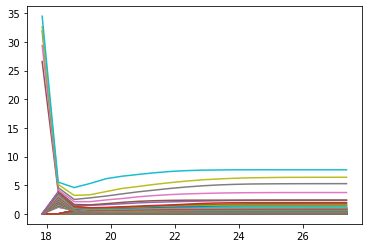

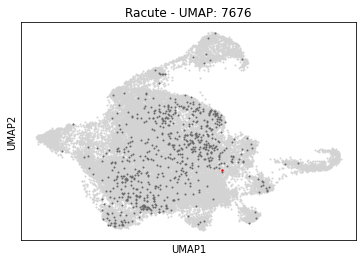

2889


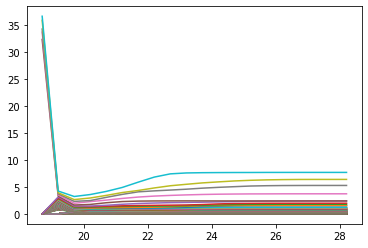

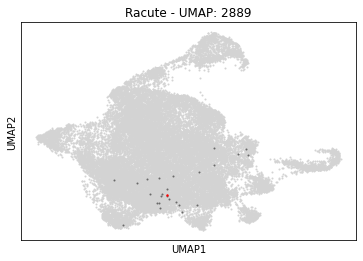

17626


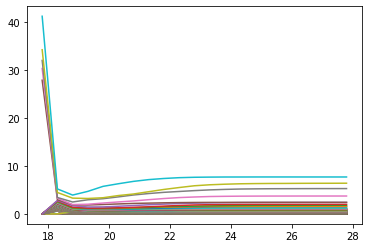

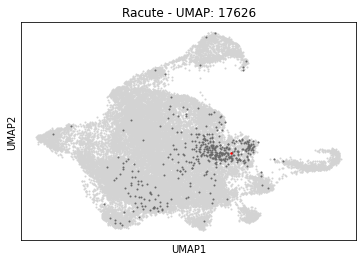

12822


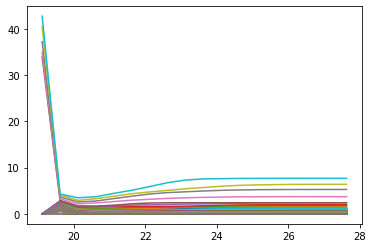

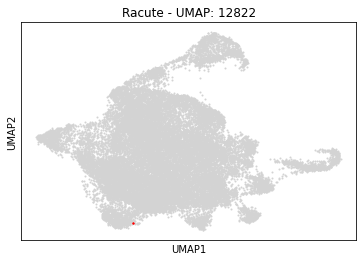

3126


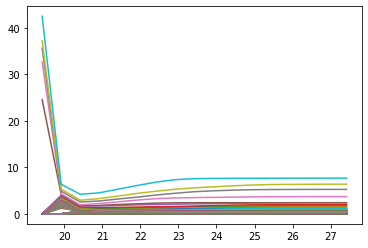

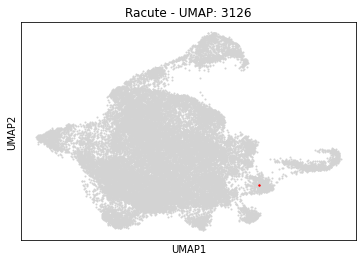

26537


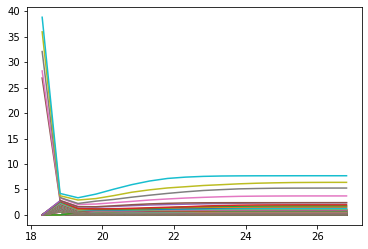

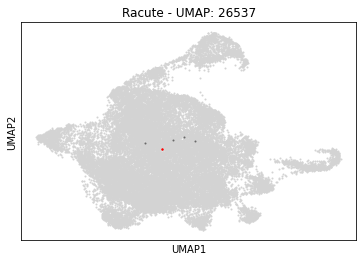

3103


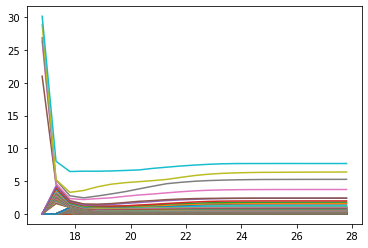

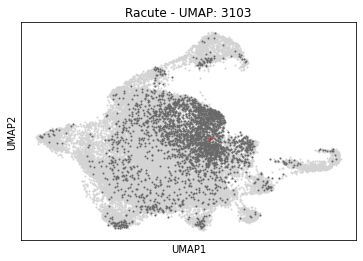

7233


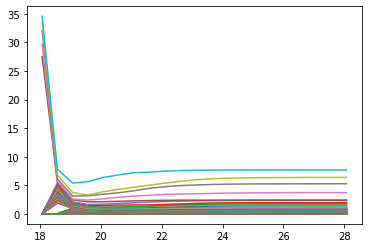

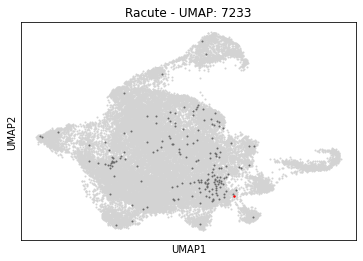

22152


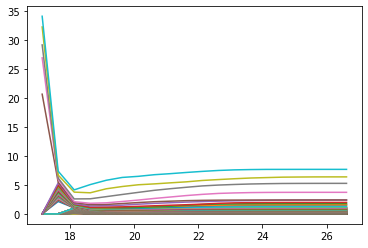

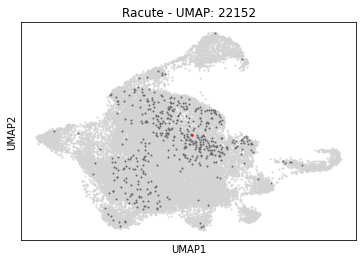

25204


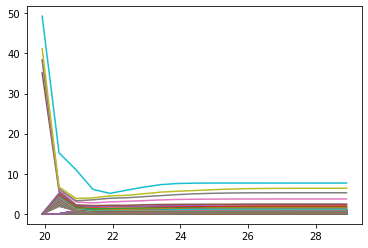

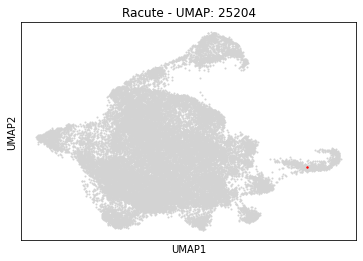

25511


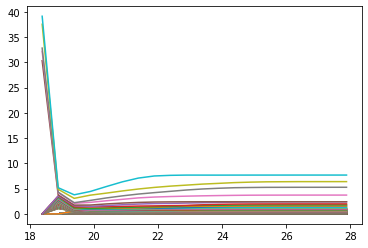

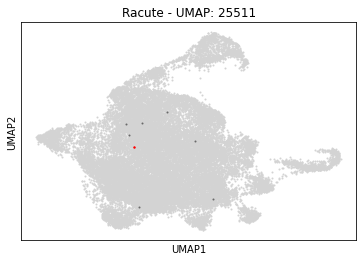

2603


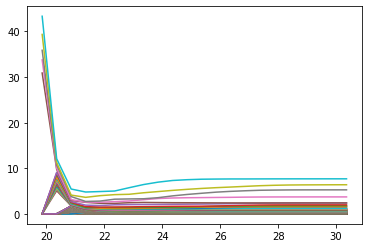

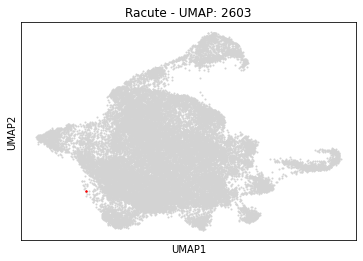

5052


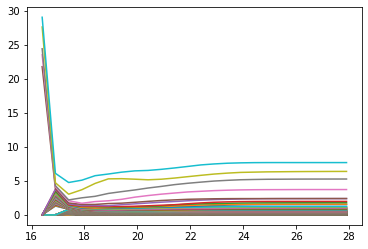

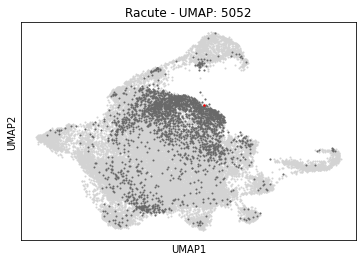

16114


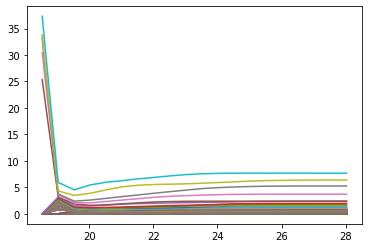

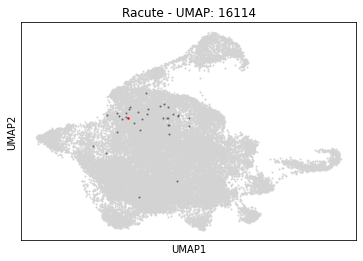

20281


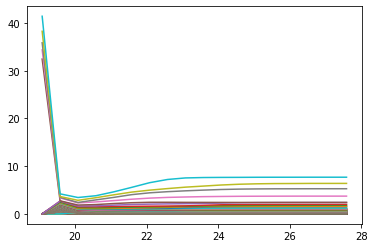

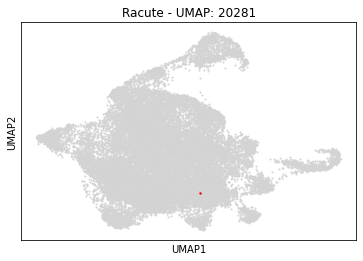

19079


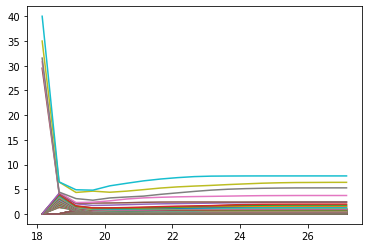

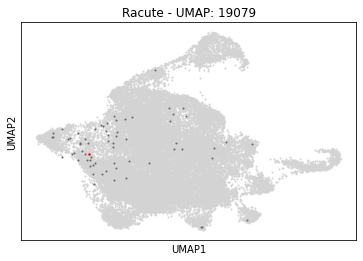

8199


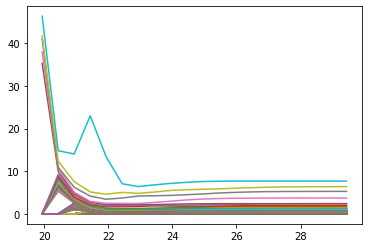

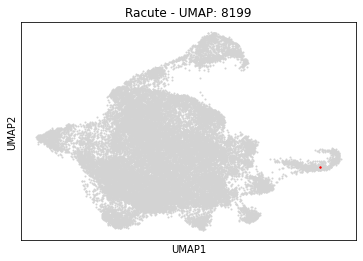

23589


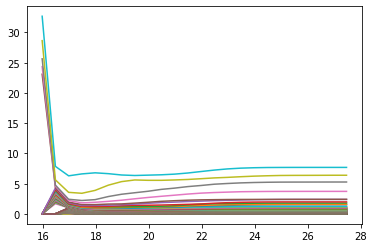

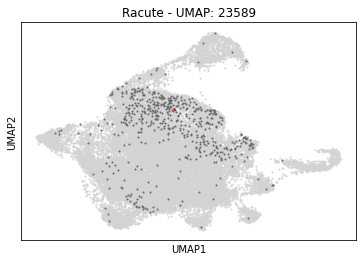

17512


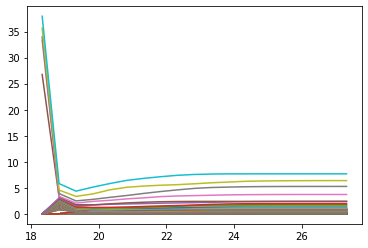

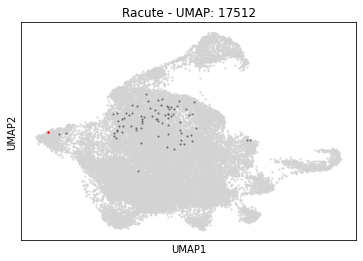

4689


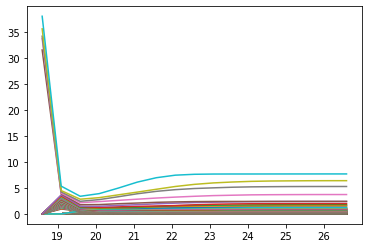

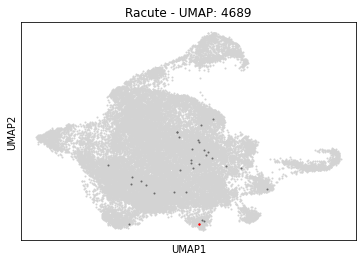

20495


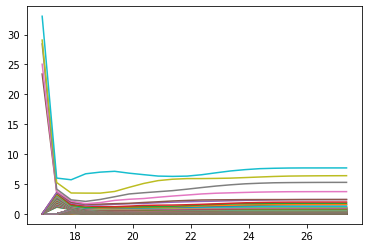

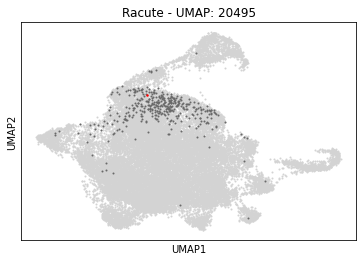

9183


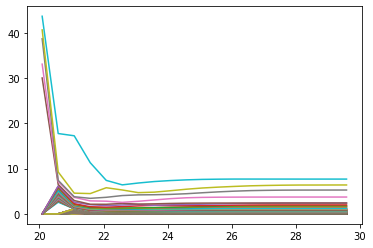

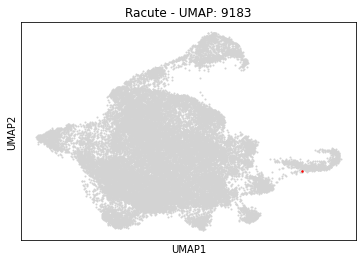

7199


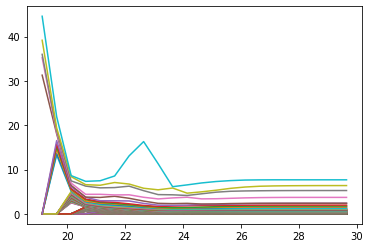

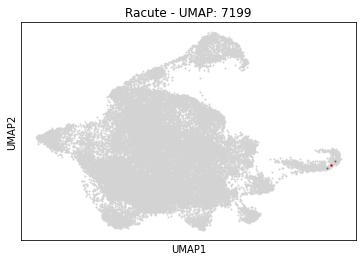

14873


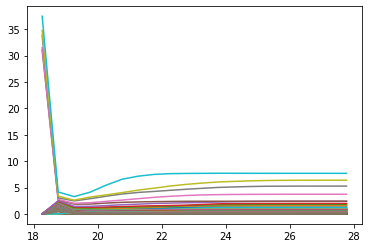

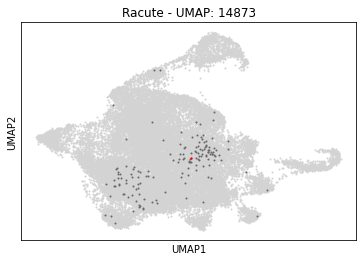

3990


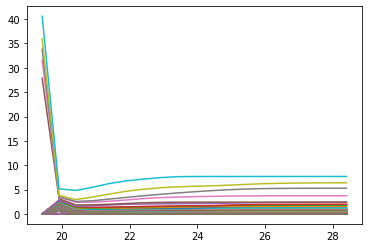

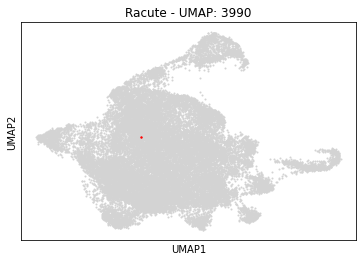

16445


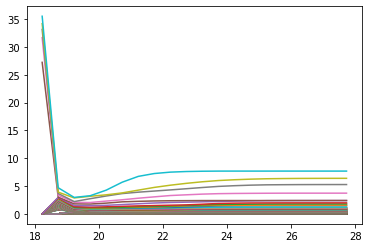

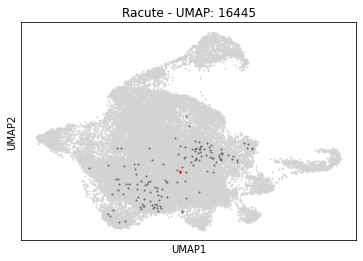

11446


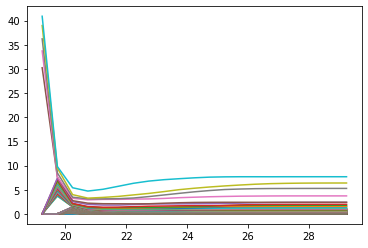

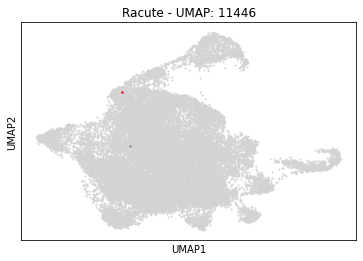

1326


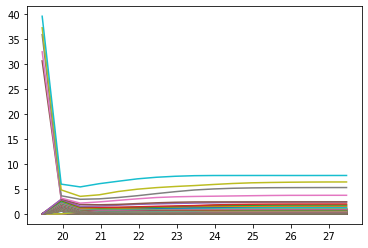

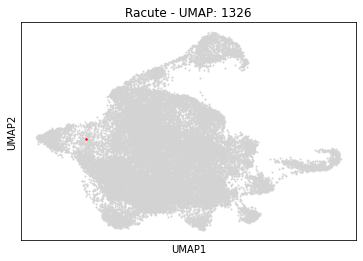

12217


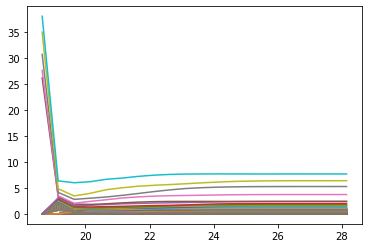

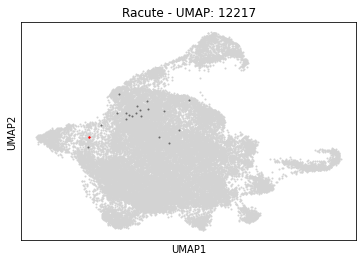

18195


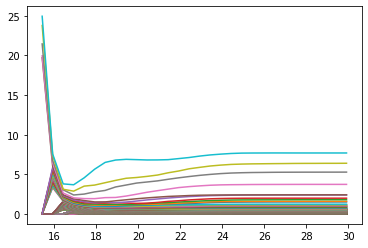

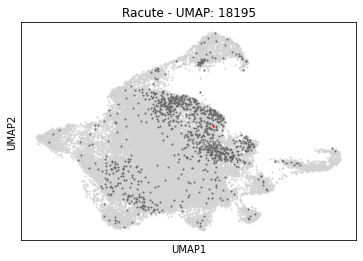

8826


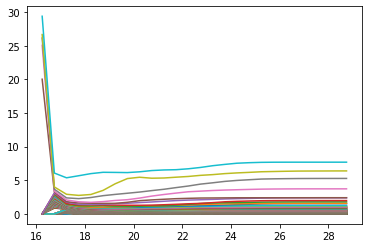

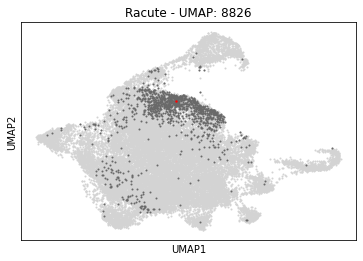

26039


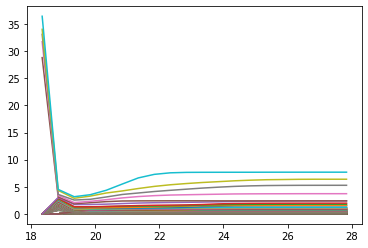

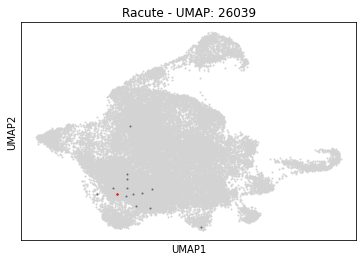

8065


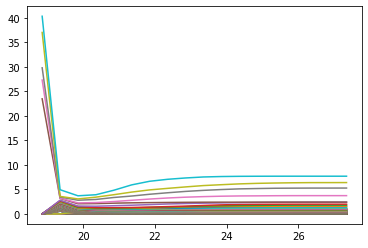

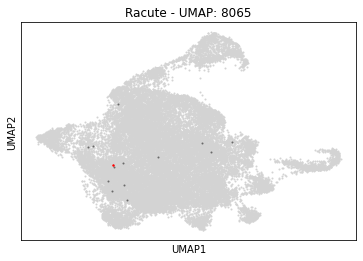

15425


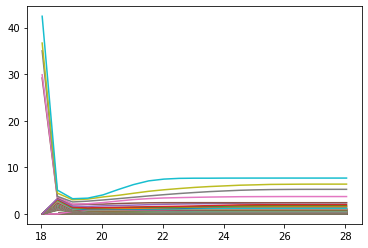

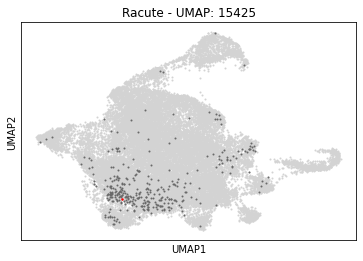

11334


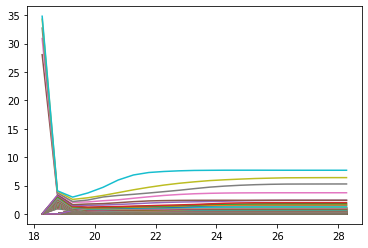

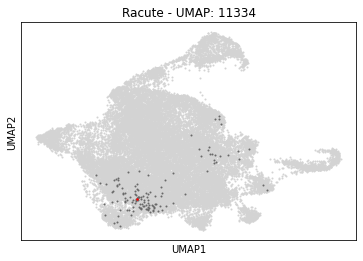

6718


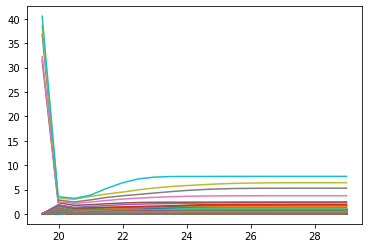

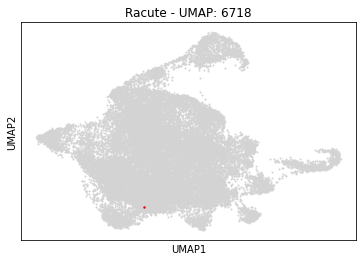

3197


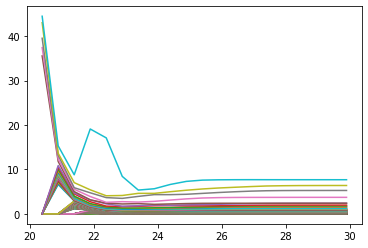

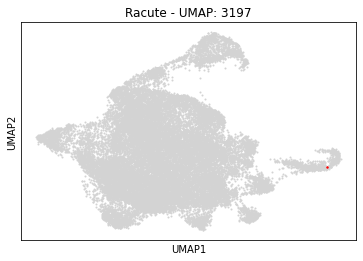

23071


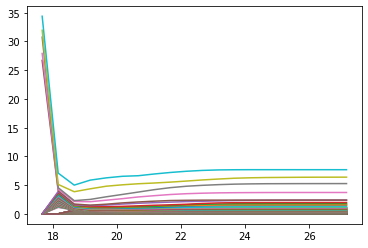

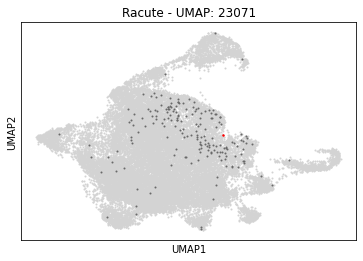

5935


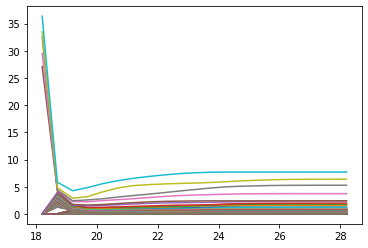

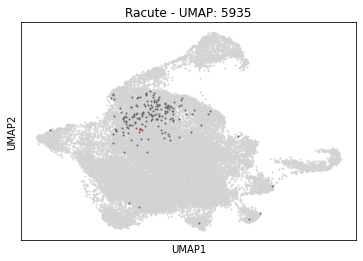

7981


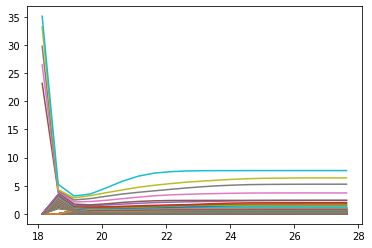

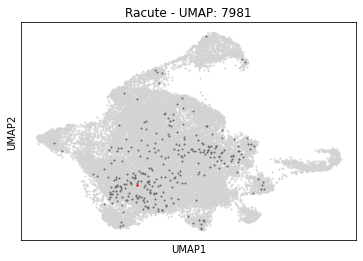

24410


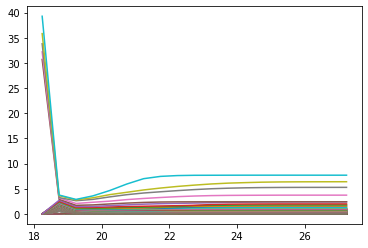

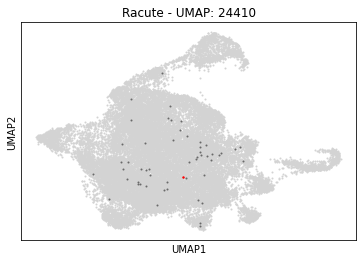

24880


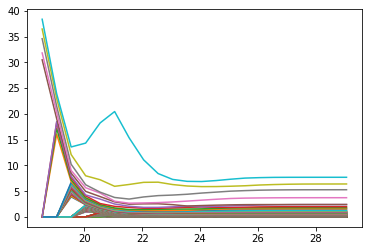

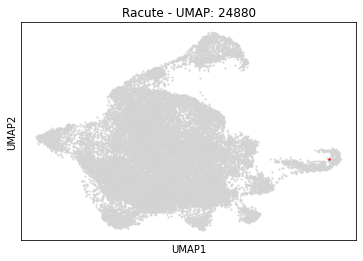

15


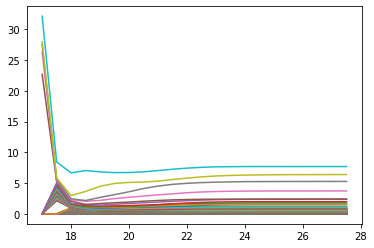

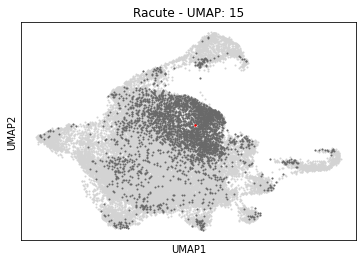

22531


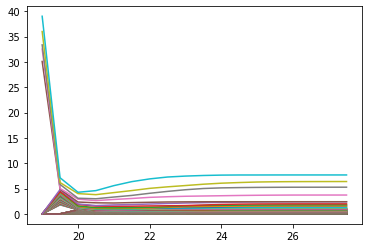

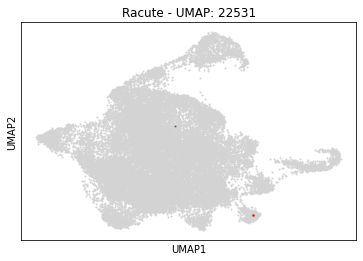

10446


KeyboardInterrupt: 

In [25]:
radius = 19

for i in range(len(landmarks)):
    print(landmarks[i])
    center = landmarks[i]
    radii, eigval_list, eigvec_list = eigen_calc_from_dist_mat(np_data, dist_mat, center, radint = 0.5)

    rmin = radii[0]
    rmax = radii[-1]
    
    eigen_plot(eigval_list, radii, rmin, rmax)
      
    landmark_loc = UMAP[center,:]
    radius_UMAP = np.zeros((1,2))
    for j in range(dist_mat.shape[0]):
        if j > center:
            if dist_mat[center,j] < radius:
                radius_UMAP = np.append(radius_UMAP, np.reshape(UMAP[j,:], (1,2)), axis = 0)
    radius_UMAP = radius_UMAP[1:,:]
    
    frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=1, c = "lightgrey")
    frame1 = plt.scatter(radius_UMAP[:,0], radius_UMAP[:,1], s=1, c = "dimgrey")
    frame1 = plt.scatter(landmark_loc[0], landmark_loc[1], s=2, c = "red")
    plt.title('Racute - UMAP: '+str(center))
    #plt.xlim(-30000,25000)
    frame1.axes.get_xaxis().set_ticks([])
    frame1.axes.get_yaxis().set_ticks([])
    plt.ylabel('UMAP2')
    plt.xlabel('UMAP1')
    plt.show()

## Mapper

In [21]:
mapper = km.KeplerMapper(verbose=3)
lens = UMAP

KeplerMapper(verbose=3)


In [24]:
# Create the simplicial complex
cubes = 20
p_o = 0.5

#n_clusters for kmeans
n_c = 2

#eps and min_samples for DBSCAN
e = 10000
m_s = 1

graph = mapper.map(lens,
                   np_data,
                   cover=km.Cover(n_cubes=cubes, perc_overlap=p_o),
                   clusterer=sklearn.cluster.KMeans(n_clusters=n_c,
                                                    random_state=1618033))

Mapping on data shaped (26877, 3000) using lens shaped (26877, 2)

Minimal points in hypercube before clustering: 2
Creating 400 hypercubes.
   > Found 2 clusters in hypercube 0.
   > Found 2 clusters in hypercube 1.
   > Found 2 clusters in hypercube 2.
   > Found 2 clusters in hypercube 3.
   > Found 2 clusters in hypercube 4.
   > Found 2 clusters in hypercube 5.
   > Found 2 clusters in hypercube 6.
   > Found 2 clusters in hypercube 7.
   > Found 2 clusters in hypercube 8.
   > Found 2 clusters in hypercube 9.
   > Found 2 clusters in hypercube 10.
   > Found 2 clusters in hypercube 11.
   > Found 2 clusters in hypercube 12.
   > Found 2 clusters in hypercube 13.
   > Found 2 clusters in hypercube 14.
   > Found 2 clusters in hypercube 15.
   > Found 2 clusters in hypercube 16.
   > Found 2 clusters in hypercube 17.
   > Found 2 clusters in hypercube 18.
   > Found 2 clusters in hypercube 19.
   > Found 2 clusters in hypercube 20.
   > Found 2 clusters in hypercube 21.
   > Found 

   > Found 2 clusters in hypercube 209.
   > Found 2 clusters in hypercube 210.
   > Found 2 clusters in hypercube 211.
   > Found 2 clusters in hypercube 212.
   > Found 2 clusters in hypercube 213.
   > Found 2 clusters in hypercube 214.
   > Found 2 clusters in hypercube 215.
   > Found 2 clusters in hypercube 216.
   > Found 2 clusters in hypercube 217.
   > Found 2 clusters in hypercube 218.
   > Found 2 clusters in hypercube 219.
   > Found 2 clusters in hypercube 220.
   > Found 2 clusters in hypercube 221.
   > Found 2 clusters in hypercube 222.
   > Found 2 clusters in hypercube 223.
   > Found 2 clusters in hypercube 224.
   > Found 2 clusters in hypercube 225.
   > Found 2 clusters in hypercube 226.
   > Found 2 clusters in hypercube 227.
   > Found 2 clusters in hypercube 228.
   > Found 2 clusters in hypercube 229.
   > Found 2 clusters in hypercube 230.
   > Found 2 clusters in hypercube 231.
   > Found 2 clusters in hypercube 232.
   > Found 2 clusters in hypercube 233.


In [25]:
fig = plotlyviz(graph)
fig

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,180)', 'width':…